In [1]:
%matplotlib inline
import os
import json
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.image import imread
import torch
from analyze import load_model, load_image_tensor
sys.path.append('visual_attribution')
from explainer.gradcam import GradCAMExplainer
from torch._thnn import type2backend
from torch.autograd import Variable
from torch.nn.functional import interpolate
import numpy as np
from bounding_box import draw_bbox

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset, loader, model = load_model(device)
num_classes = len(dataset.classes)

In [3]:
def get_class_name(label):
    return dataset.classes[label]

def get_class_id(label):
    return dataset.classes.index(label)

In [4]:
def plot_cam(attr, xi, label, cmap='jet', alpha=0.5):
    attr -= attr.min()
    attr /= (attr.max() + 1e-20)
    plt.imshow(xi)
    plt.imshow(attr, alpha=alpha, cmap=cmap)

def upsample(inp, size):
    scale = size / inp.shape[3]
    return interpolate(inp, scale_factor=scale, mode='bilinear', align_corners=False)

def explain(filename, label):
    image_class = get_class_id(label)
    image, tensor = load_image_tensor('../data/processed_images/' + filename, device=device, unsqueeze=True)
    tensor = Variable(tensor, requires_grad=True)
    explainer = GradCAMExplainer(model, target_layer_name_keys=['features', 'norm5'])
    target = torch.LongTensor([image_class]).to(device)
    saliency = explainer.explain(tensor, target)
    saliency = upsample(saliency, image.width)
    saliency = saliency.cpu().numpy()
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    bbox_image = image.copy()
    draw_bbox(filename, bbox_image)
    plt.imshow(bbox_image)
    plt.title(label)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plot_cam(np.abs(saliency).max(axis=1).squeeze(), image, label, 'jet', alpha=0.5)
    plt.show()

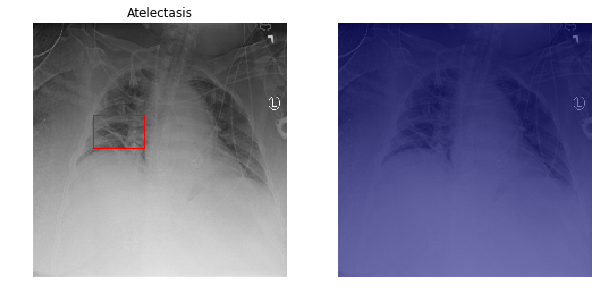

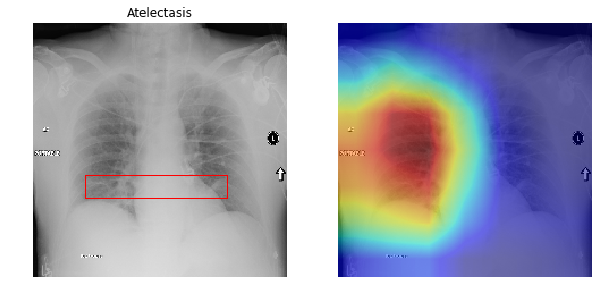

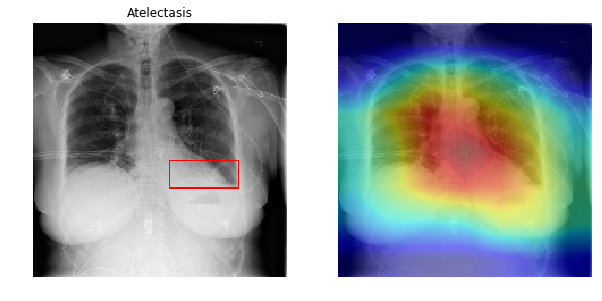

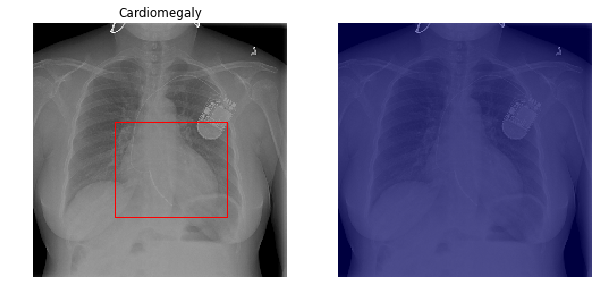

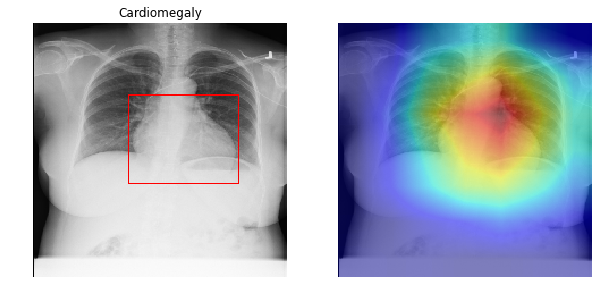

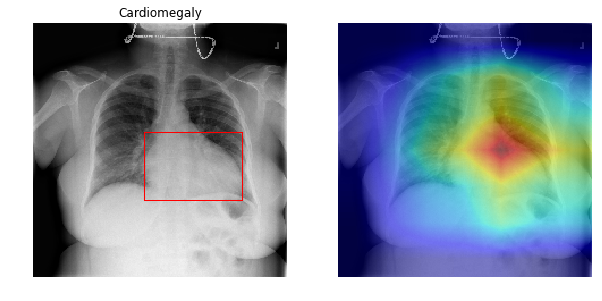

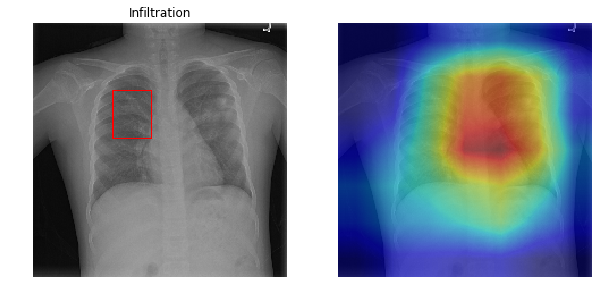

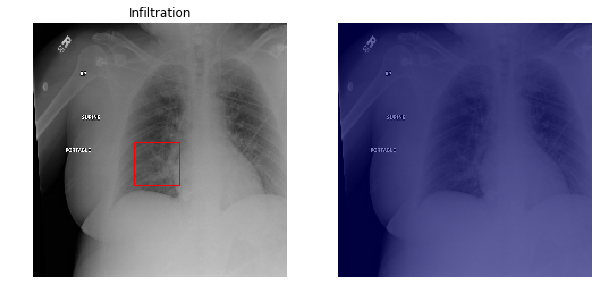

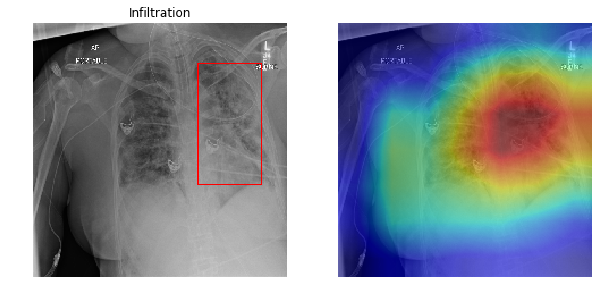

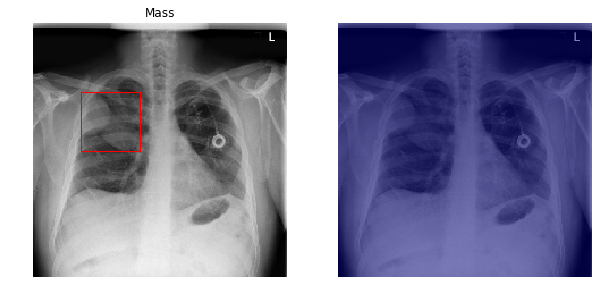

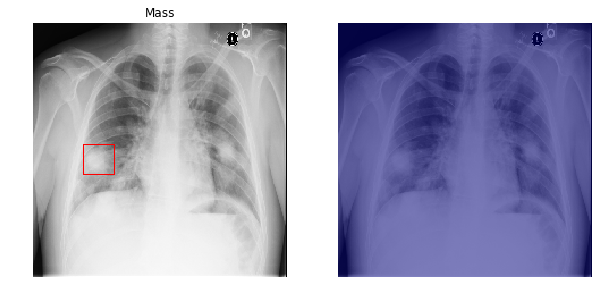

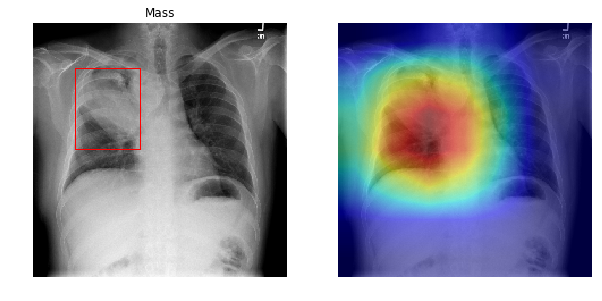

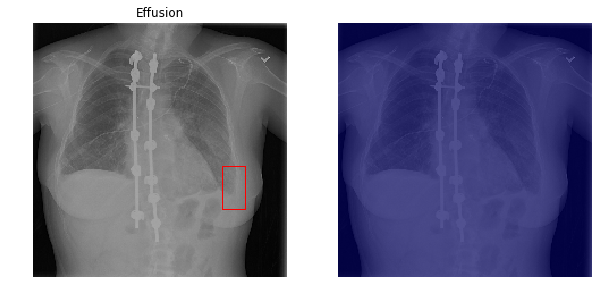

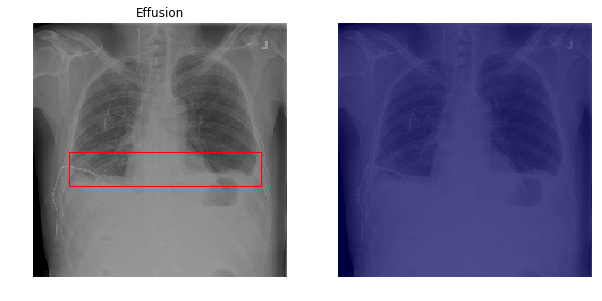

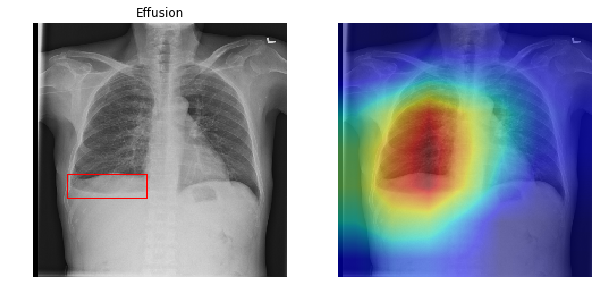

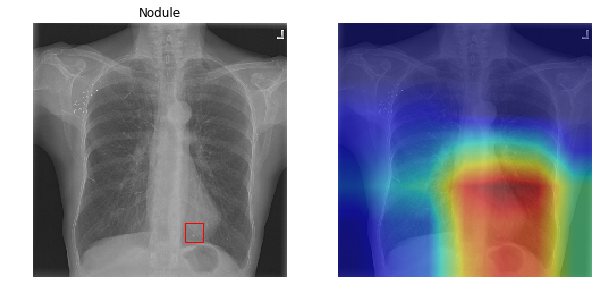

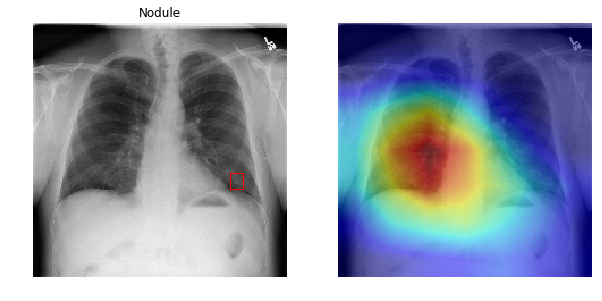

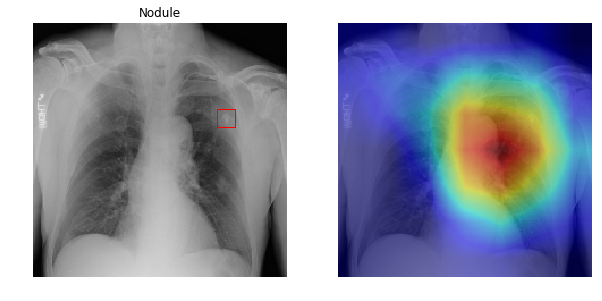

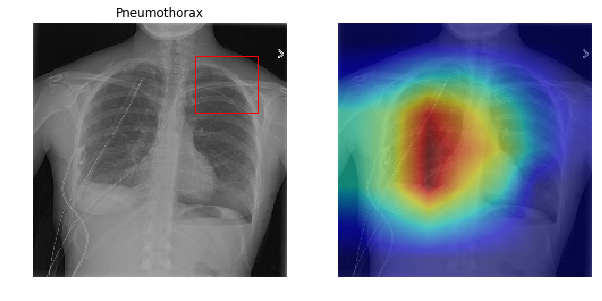

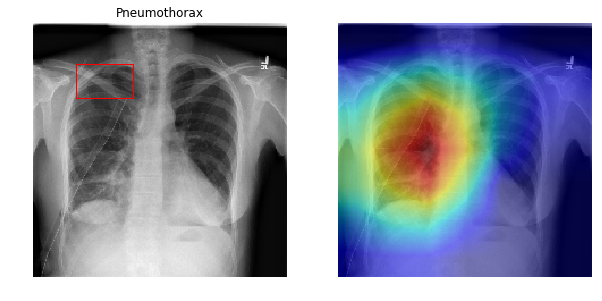

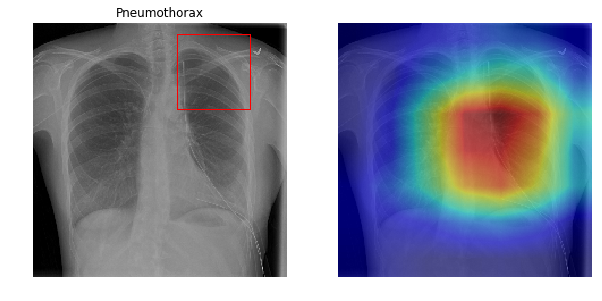

In [5]:
with open('best10_bbox.json') as f:
    json_data = json.load(f)
data = {}
for label, images in json_data.items():
    if len(images) > 0:
        data[label] = images

for label, images in data.items():
    for image in images[:3]:
        explain(image['image'], label)